In [1]:
%load_ext autoreload
%autoreload 2

# Environment prep for Colab
 - download git repo 
 - install required pip packages

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!git clone https://github.com/kkahloots/Rethinking_Data_Effeient_GANs.git

In [4]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#!wget https://hanlab.mit.edu/projects/data-efficient-gans/datasets/AnimalFace-cat.zip 

In [6]:
#!mkdir  Rethinking_Data_Effeient_GANs/data/.AnimalFace-cat
#!mkdir  "Rethinking_Data_Effeient_GANs/data/.AnimalFace-cat/1"

In [7]:
#!unzip ./AnimalFace-cat.zip -d "Rethinking_Data_Effeient_GANs/data/.AnimalFace-cat/1"

In [8]:
#!rm -rf ./AnimalFace-cat.zip

# Connect Drive to save and restore results

# Settings

In [9]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
print(sep_local)

env: TF_KERAS=1
\


In [10]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [11]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
os.getcwd()

'C:\\Users\\Kriple\\PycharmProjects\\pythonProject\\Rethinking_Data_Effeient_GANs\\notebooks\\AugmentationDemo'

In [13]:
os.chdir('../../')
print(os.getcwd())

C:\Users\Kriple\PycharmProjects\pythonProject\Rethinking_Data_Effeient_GANs


# only on colab

# Dataset loading

In [14]:
#!pip install -q colorlog tqdm Augmentor livelossplot

In [15]:
from generators.from_images.file_image_generator import get_generators, create_image_lists

In [16]:
dataset_name='100-shot-obama'
inputs_shape= image_shape=(256, 256, 3)
batch_size = 36
latents_dim = 256
intermediate_dim = 50
img_dir = f'data/.{dataset_name}'

In [17]:
restore_path = f'./saved_models/{dataset_name}'

In [18]:
from pathlib import Path
Path(restore_path).mkdir(parents=True, exist_ok=True)

In [19]:
import pickle

In [20]:
try:
    imgs_list = pickle.load(open(f'{restore_path}/{dataset_name}_images_list.pkl', 'rb'))
except:
    imgs_list = create_image_lists(
    image_dir=img_dir, 
    validation_pct=0, 
    valid_imgae_formats='jpg')
    pickle.dump(imgs_list, open(f'{restore_path}/{dataset_name}_images_list.pkl', 'wb'))


In [21]:
train_generator, val_generator = get_generators(
        images_list=imgs_list, 
        image_shape=image_shape, 
        image_dir=img_dir,
        batch_size=batch_size,
        episode_len=None,
        episode_shift=None,
        class_mode=None
        )

  INFO     | Found 100 training files
  INFO     | Found 0 validation files


In [22]:
from utils.utils import img_merge
from PIL import Image
import numpy as np

C:\Users\Kriple\PycharmProjects\pythonProject\Rethinking_Data_Effeient_GANs\utils\utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [23]:
batch = next(train_generator)
image_grid = img_merge(batch.numpy(), n_rows=6).squeeze()

In [24]:
#Image.fromarray(image_grid)

In [25]:
# from augmentation.augmentor import Augmentor
# from tqdm.notebook import tqdm 
# augmentor = Augmentor()

In [26]:
# for i in tqdm(range(10)):

#     aug_batch = augmentor.augment(batch, batch_shape= [batch_size, *image_shape],print_fn=True, scale=1.0)
#     #print(aug_batch[1])
#     aug_batch = aug_batch[0]
#     aug_batch = img_merge(aug_batch.numpy(), n_rows=6).squeeze() 
#     aug_batch = Image.fromarray(aug_batch)
#     aug_batch.save( f"./notebooks/AugmentationDemo/{dataset_name}/{i}.jpg", "JPEG")

In [27]:
#xxxx

In [28]:
# from augmentation.Cutout import rand_mask, cutout

In [29]:
# mask = rand_mask(36, 256, 256 , 0.2)

In [30]:
# cutbatch = cutout(images=batch, mask=mask)
# image_grid = img_merge(cutbatch.numpy(), n_rows=6).squeeze()
# Image.fromarray(image_grid)

In [31]:
import tensorflow_addons as tfa

In [32]:
def dilation2d(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    kernel = tf.ones((5, 5, c))
    output4D = tf.nn.dilation2d(img4D, filters=kernel, strides=(1,1,1,1), dilations=(1,1,1,1),
                                data_format='NHWC', padding="SAME")
    output4D = output4D - tf.ones_like(output4D)
    
    return output4D


In [33]:
def erosion2d(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    kernel = tf.ones((5, 5, c))
    output4D = tf.nn.erosion2d(img4D, filters=kernel, strides=(1,1,1,1), dilations=(1,1,1,1),
                                data_format='NHWC', padding="SAME")
    
    return output4D

In [34]:
def equalize(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    kernel = tf.ones((5, 5, c))
    output4D = tfa.image.equalize(img4D, data_format='channels_last')
    
    return output4D

In [36]:
def sharpness15(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    output4D = tfa.image.color_ops.sharpness(img4D, 1.5)
    
    return output4D

In [37]:
def sharpness05(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    kernel = tf.ones((5, 5, c))
    output4D = tfa.image.color_ops.sharpness(img4D, 0.5)
    
    return output4D

In [38]:
def gaussian05(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    #kernel = tf.ones((5, 5))
    output4D = tfa.image.gaussian_filter2d(img4D, filter_shape=(5, 5), sigma=0.5)
    
    return output4D

In [39]:
def gaussian15(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    #kernel = tf.ones((5, 5))
    output4D = tfa.image.gaussian_filter2d(img4D, filter_shape=(5, 5), sigma=1.5)
    
    return output4D

In [40]:
def mean_filter(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    #kernel = tf.ones((5, 5))
    output4D = tfa.image.mean_filter2d(img4D)
    
    return output4D

In [58]:
def median_filter(img4D):
    b, h, w, c = img4D.get_shape().as_list()
    images = []
    for i in range(len(img4D)):
        images += [ tfa.image.median_filter2d(img4D[i], filter_shape=(5, 5))]
    
    return tf.stack(images)

In [51]:
import cv2
def bilateral_filter10(images):


    def _py_filter(img):
        images = []
        for i in range(len(img)):
            images += [cv2.bilateralFilter(cv2.cvtColor(img[i].numpy().astype(np.uint8), cv2.IMREAD_COLOR), 
                                           d=5, sigmaColor=1.0, sigmaSpace=5)]
        return np.array(images)

    return tf.py_function(_py_filter, [images], tf.float32)

In [54]:
import cv2
def bilateral_filter01(images):


    def _py_filter(img):
        images = []
        for i in range(len(img)):
            images += [cv2.bilateralFilter(cv2.cvtColor(img[i].numpy().astype(np.uint8), cv2.IMREAD_COLOR), 
                                           d=5, sigmaColor=0.1, sigmaSpace=5)]
        return np.array(images)

    return tf.py_function(_py_filter, [images], tf.float32)

In [60]:
import cv2
def box_filter(images):

    def _py_filter(img):
        images = []
        for i in range(len(img)):
            images += [cv2.boxFilter(cv2.cvtColor(img[i].numpy().astype(np.uint8), cv2.IMREAD_COLOR), 
                                           ddepth=-1, ksize=(5, 5))]
        return np.array(images)

    return tf.py_function(_py_filter, [images], tf.float32)

In [ ]:
import cv2
def color_balance(images):

    def _py_filter(img):
        images = []
        for i in range(len(img)):
            images += [simplest_cb(cv2.cvtColor(img[i].numpy().astype(np.uint8), cv2.IMREAD_COLOR), 5)]
        return np.array(images)

    return tf.py_function(_py_filter, [images], tf.float32)

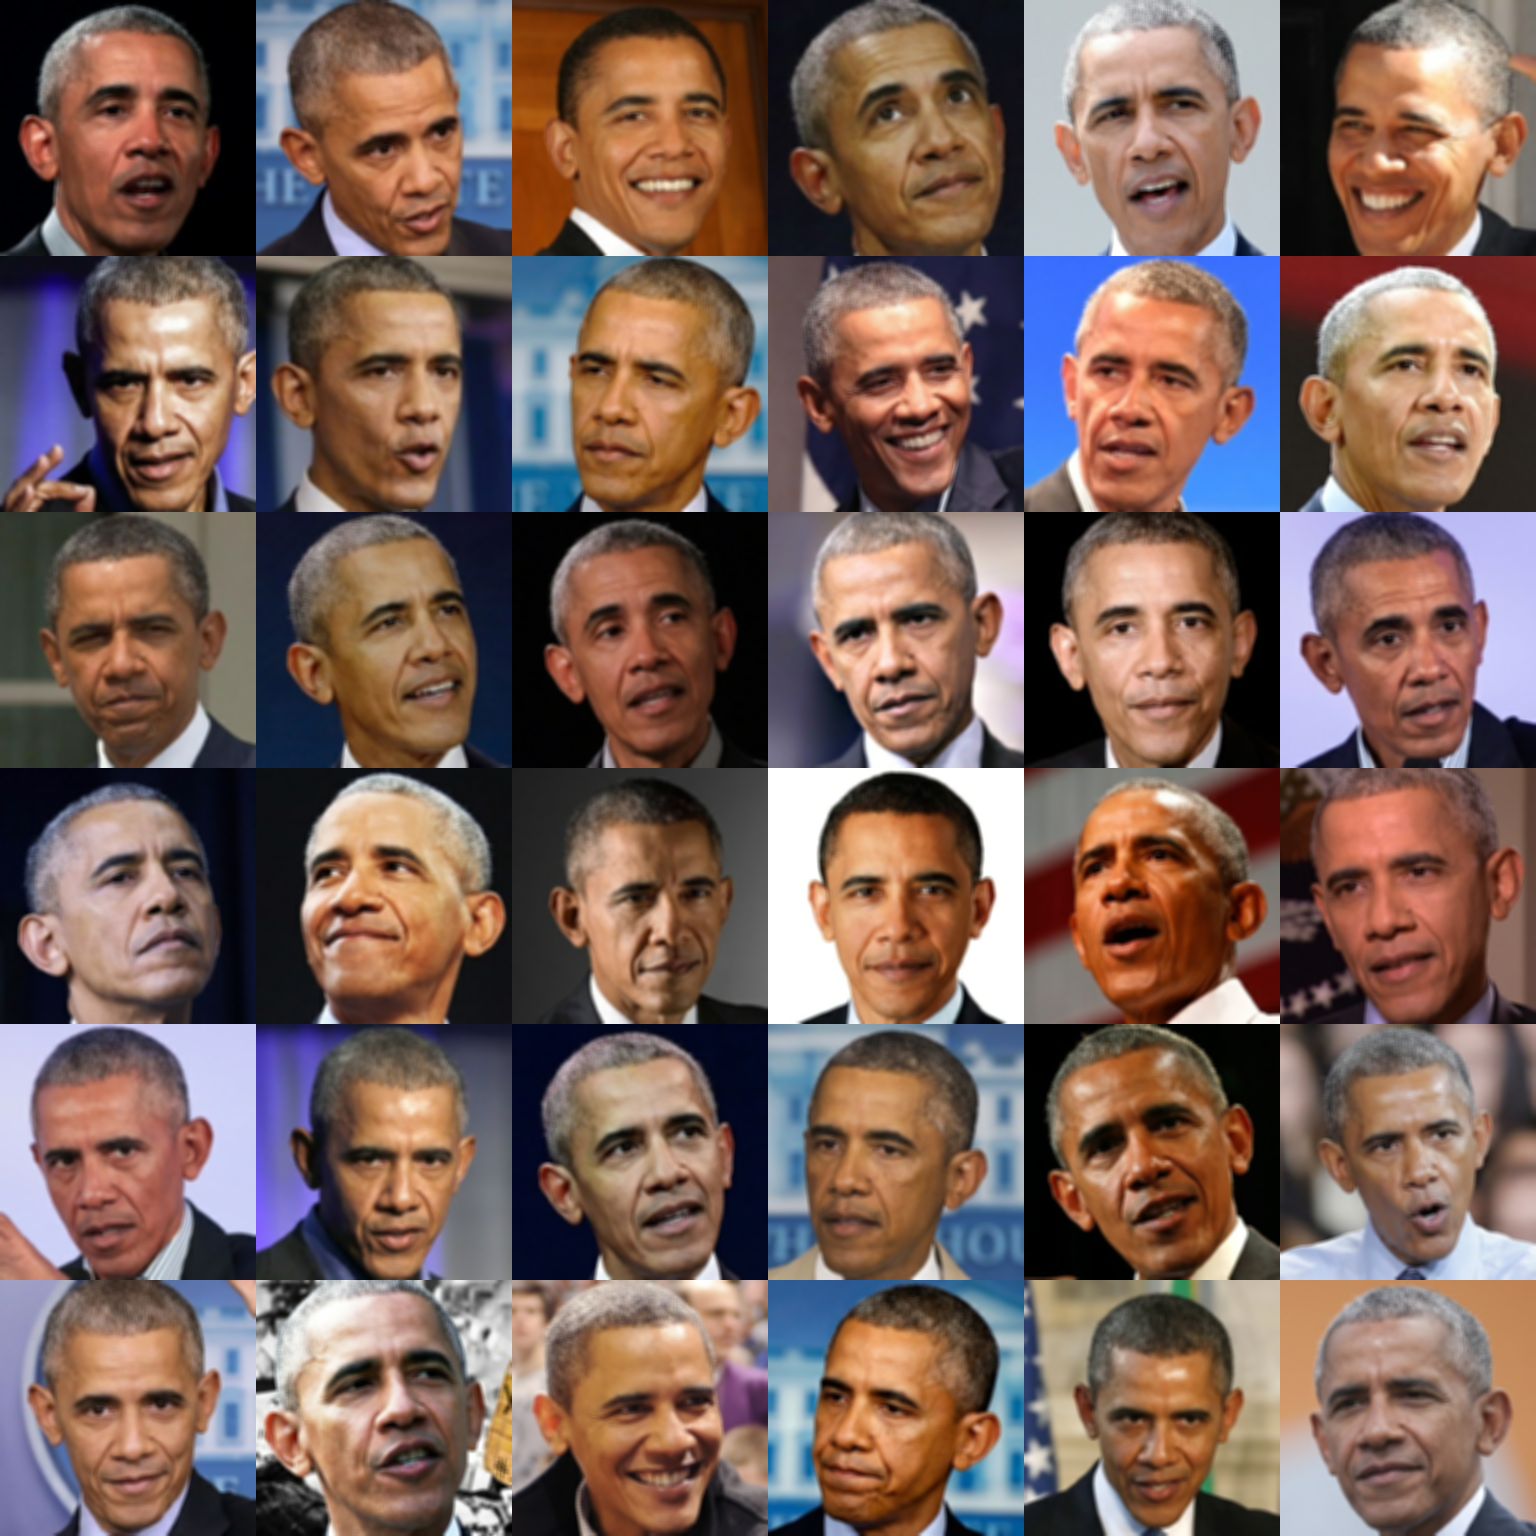

In [61]:
fbatch = box_filter(batch)
image_grid = img_merge(fbatch.numpy(), n_rows=6).squeeze()
Image.fromarray(image_grid)

In [ ]:
xxx